# Spike train trials

Here we fit a log Cox Gaussian process to inhomogeous Poisson spike train trials.

### Table of contents

1. [**Spike train trials**](#trials)
2. [**Fitting a log Cox Gaussian process**](#cox)
3. [**Evaluating the inferred intensity**](#infer)


In [1]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")


import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

PyTorch version: 1.13.0+cu117
Using device: cuda:0


<a id="trials"></a>
## 1. Spike train trials

In [2]:
tbin = 0.001
steps = 1000
max_time = tbin*steps
trials = 10
neurons = 2

rate = np.empty((trials, neurons, steps))
rate[:, 0, :] = (20.0*np.sin(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)
rate[:, 1, :] = (20.0*np.cos(2*np.pi*np.arange(steps)/1000) + 20.0)[None, :].repeat(trials, axis=0)

rng = np.random.default_rng(123)  # seed RNG
spikes = rng.binomial(1, rate * tbin)  # (trials, neurons, ts)

times = np.arange(steps)*tbin # time points to evaluate
covariates = times[None, :, None].repeat(trials, axis=0) # input regressors of shape (trials, time, dimensions)


t_spike = []
for tr in range(trials):
    t_spike_ = []
    for n in range(neurons):
        t_spike_.append(np.where(spikes[tr, n, :] > 0)[0])
        
    t_spike.append(t_spike_)

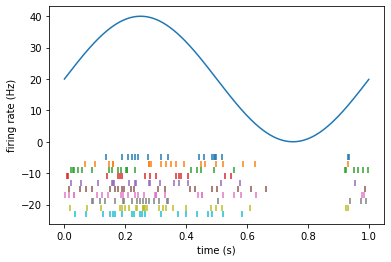

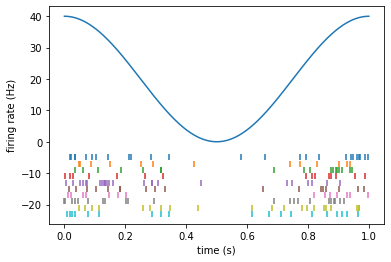

In [3]:
for n  in range(neurons):

    plt.plot(times, rate[0, n])
    for tr in range(trials):
        plt.scatter(t_spike[tr][n]*tbin, (-5.0-2*tr)*np.ones_like(t_spike[tr][n]), marker='|')
    plt.xlabel('time (s)')
    plt.ylabel('firing rate (Hz)')
    plt.show()

<a id="cox"></a>
## 2. Fitting a log Cox Gaussian process

Note we use the [sparse variational Gaussian process](https://arxiv.org/abs/1309.6835) to handle non-conjugate likelihoods and enable scalability to many time points (trading off expressivity of the inferred posterior).

In [4]:
out_dims = neurons

# kernel
l = 1.*torch.ones(1, out_dims)
v = torch.ones(out_dims)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inputs
input_data = [
    torch.from_numpy(times[None, None, :, None].repeat(trials, axis=0)), 
    # for trial structure, inputs have shapes (trials, out_dims, ts, dims)
]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, steps, batch_info=500, trials=trials)

# inducing points
num_induc = 12
Xu = np.array(
    [np.linspace(0, max_time, num_induc)]
).T[None, ...].repeat(out_dims, axis=0)
inducing_points = nprb.mappings.inducing_points(
    out_dims, torch.from_numpy(Xu), jitter=1e-5)


# mapping
in_dims = Xu.shape[-1]

gp = nprb.mappings.SVGP(
    in_dims, neurons, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-5, mean=torch.zeros(neurons), learn_mean=True
)

# likelihood
likelihood = nprb.likelihoods.discrete.Poisson(tbin, neurons, 'exp')
likelihood.set_Y(torch.from_numpy(spikes), batch_info=500) 

# assemble
gpr = nprb.inference.VI_optimized(input_group, gp, likelihood)
gpr.to(dev)

VI_optimized(
  (input_group): input_group()
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Poisson()
)

In [5]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.99)
opt_lr_dict = {
    'default': 1e-2, 
}

gpr.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gpr.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=1, ll_mode='MC')

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 1602.


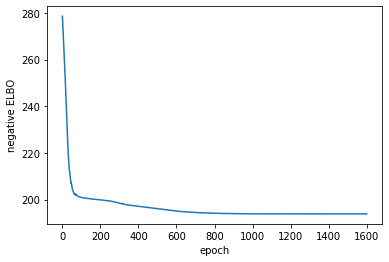

In [6]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id="infer"></a>
## 3. Evaluating the inferred intensity

In [7]:
# compare to true rate
steps= 100
show_neurons = list(range(neurons))
eval_times = np.linspace(0.0, max_time, steps)[None, :]  # (dims, timesteps)

lower, mean, upper = [
    p.cpu().numpy() for p in utils.model.posterior_rate(gp, likelihood.f, torch.from_numpy(eval_times), 1000, show_neurons)
]

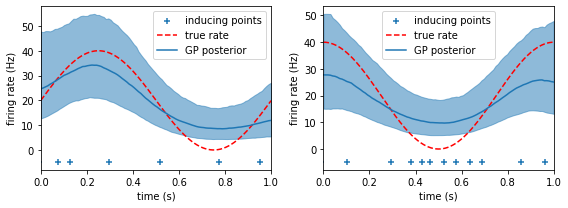

In [8]:
visualize_trial = 0

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# intensity and uncertainty
for k in show_neurons:
    ax = axes[k]
    
    Xu = gp.induc_pts.Xu.data.cpu().numpy()[k, :, 0]
    ax.scatter(Xu, -5.0*np.ones_like(Xu), marker='+', label='inducing points')
    ax.set_xlim(eval_times[0, 0], eval_times[0, -1])
    
    ax.plot(np.linspace(0, max_time, rate.shape[-1]), rate[visualize_trial, k], 'r--', label='true rate')
    line, = ax.plot(eval_times[0], mean[k], label='GP posterior')
    ax.fill_between(
        eval_times[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.legend()
    
    
fig.tight_layout()
plt.show()